#  Bias-Variance Tradeoff

In [6]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import pandas as pd
# fix random seed for reproducibility
np.random.seed(7)



Given an input $x\in\mathbb{R}$, we can create other features such as $x^2$, $x^3$ ... $x^p$, etc.

We can fit a polynomial of degree $p$ to the data:

$$f(x) = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + ... + \beta_p x^p$$

This is sometimes called a polynomial regression, but it is still a linear regression: as we are seeking a linear combination of the polynomial features. The design matrix is:

$$X = \begin{bmatrix} 1 & x_1 & x_1^2 & x_1^3 & ... & x_1^p \\ 1 & x_2 & x_2^2 & x_2^3 & ... & x_2^p \\ ... & ... & ... & ... & ... & ... \\ 1 & x_N & x_N^2 & x_N^3 & ... & x_N^p \end{bmatrix}$$



Note that if we have $(x_0, y_0)$, $(x_1, y_1)$, ..., $(x_n, y_n)$, and the $x_i$'s are different, then there is always a polynomial of degree $n$ that passes through all the points. 
In this case, the design matrix is a square invertible matrix, and therefore $X\beta = y$ has a unique solution.
This is called interpolation.


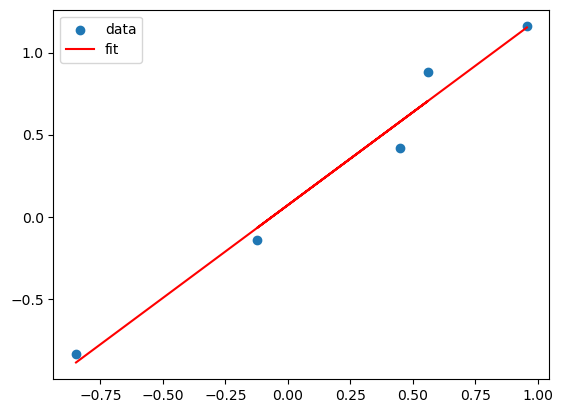

In [7]:
# Suppos the true model is a linear model of x

N = 5
X = np.random.uniform(-1,1,N)
Y = X + np.random.normal(0,0.1,N)

X = X.reshape(-1,1)
lreg_sklearn = linear_model.LinearRegression()
lreg_sklearn.fit(X,Y) 



plt.scatter(X,Y)
plt.plot(X, lreg_sklearn.predict(X), color='red')
plt.legend(['data', 'fit'])


[-1.1329286   6.40789176  3.50868941 -7.55811971] -0.3673693141494301


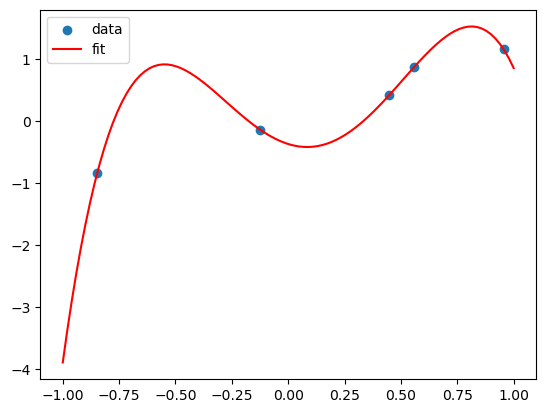

In [8]:
X_poly = np.hstack((X,X**2,X**3,X**4))
lreg_sklearn.fit(X_poly,Y) 
lreg_sklearn.score(X_poly,Y)


print(lreg_sklearn.coef_, lreg_sklearn.intercept_)
x_grid = np.linspace(-1,1,100) 
y_grid = lreg_sklearn.coef_[0]*x + lreg_sklearn.coef_[1]*x**2 + lreg_sklearn.coef_[2]*x**3 + lreg_sklearn.coef_[3]*x**4 + lreg_sklearn.intercept_
plt.scatter(X,Y)
plt.plot(x_grid, y_grid, color='red')
plt.legend(['data', 'fit'])

This polynomial can fit all the data! But is it a good fit?

This is called overfitting. We can add more and more features to fit the data, but this might not generalize well to new data.

To show this, we split the dataset into a training set and a test set. We fit the model on the training set and evaluate it on the test set.

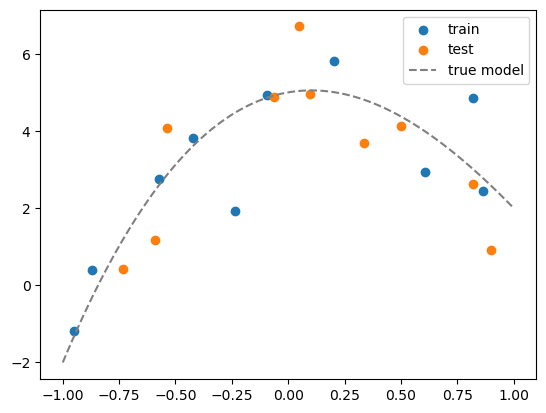

In [9]:
from sklearn.model_selection import train_test_split

# generate N data, this is the whole population
N = 20
x = np.random.uniform(-1,1,N)
Y = x + np.random.normal(0,0.1,N)
x = x.reshape(-1,1)


# maximum degree of the polynomial
degree = 7

# create a dataframe of all the polynomial features
X = np.hstack([x**i for i in range(degree+1)])

# convert to a pandas dataframe
df = pd.DataFrame(X, columns=['x%d'%i for i in range(degree+1)])
df.head()

# suppose the true model is a polynomial of degree 3
coeff = [5, 1, -5, 1]
df['y_true'] = sum([c*df[f'x{i}'] for i,c in enumerate(coeff)])

# add some noise to get data
df['y'] = df['y_true'] + np.random.normal(0,1,N)

# split the data into training and test sets 
df_train = df.iloc[:int(N/2)]
df_test = df.iloc[int(N/2):]

# visualize the data
plt.scatter(df_train['x1'], df_train['y'])
plt.scatter(df_test['x1'], df_test['y'])
# plot the true model
x_grid = np.linspace(-1,1,100)
y_grid = sum([c*x_grid**i for i,c in enumerate(coeff)])
plt.plot(x_grid, y_grid, color='gray', linestyle='--')
plt.legend(['train', 'test','true model'])

In [10]:
# For plotting, we need to create a grid of x values and its corresponding polynomial features
x_grid = np.linspace(-1,1,100).reshape(-1,1) 
X_grid = np.hstack([x_grid**i for i in range(degree+1)])
df_grid = pd.DataFrame(X_grid, columns=['x%d'%i for i in range(degree+1)])
df_grid.head()

x0        x1        x2        x3        x4        x5        x6        x7
0  1.0 -1.000000  1.000000 -1.000000  1.000000 -1.000000  1.000000 -1.000000
1  1.0 -0.979798  0.960004 -0.940610  0.921608 -0.902989  0.884747 -0.866874
2  1.0 -0.959596  0.920824 -0.883619  0.847918 -0.813658  0.780783 -0.749236
3  1.0 -0.939394  0.882461 -0.828978  0.778737 -0.731541  0.687205 -0.645557
4  1.0 -0.919192  0.844914 -0.776638  0.713879 -0.656192  0.603166 -0.554426

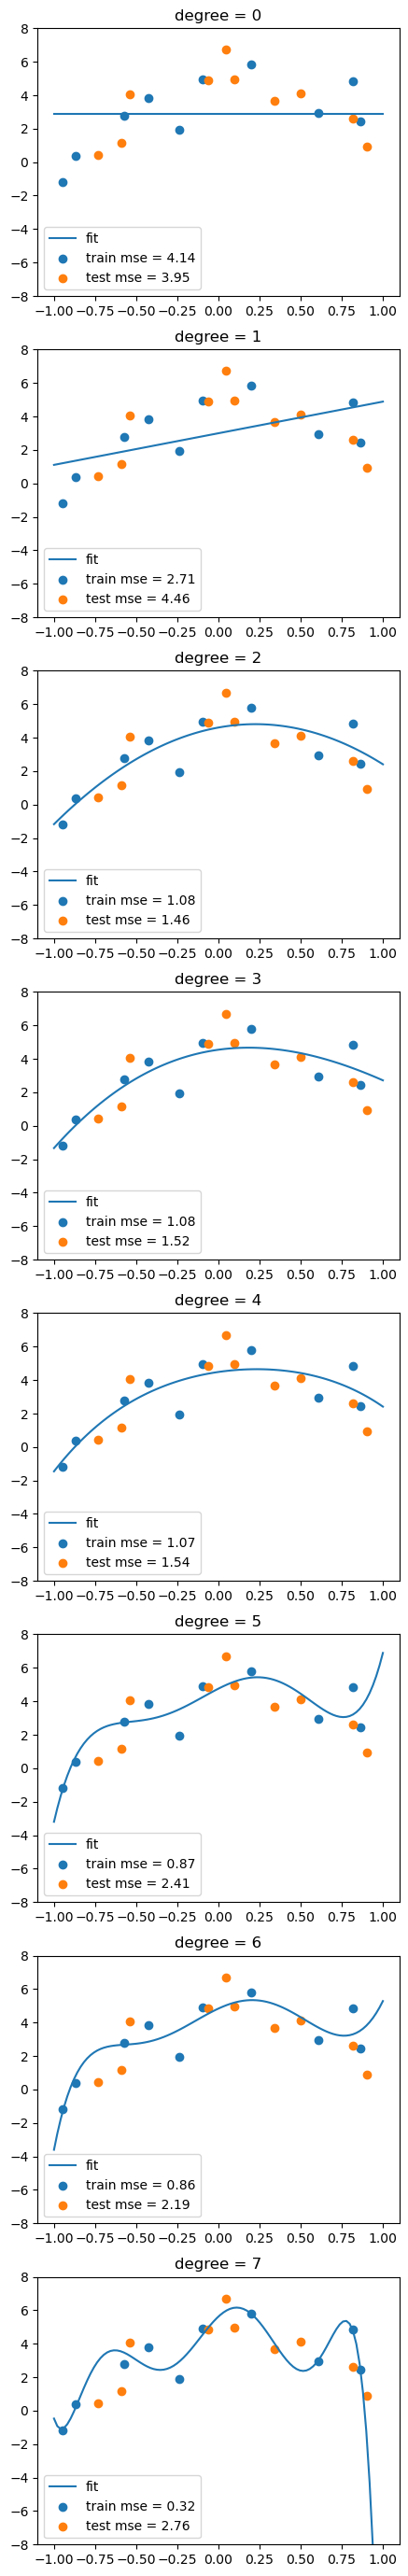

In [11]:
# for each degree, fit a polynomial model
from sklearn.metrics import mean_squared_error

# our features already include the constant term
lreg = linear_model.LinearRegression(fit_intercept=False)

train_mse = []
test_mse = []

fig, axs = plt.subplots(degree+1, 1, figsize=(5,degree*5))

# fit a polynomial model for each degree
for d in range(degree+1):

    # fit the model
    Xtrain_poly = df_train.iloc[:,:d+1]
    Xtest_poly = df_test.iloc[:,:d+1]
    
    lreg.fit(Xtrain_poly, df_train['y'])

    # calculate the MSE on training and test sets
    train_mse.append(mean_squared_error(df_train['y'], lreg.predict(Xtrain_poly)))
    test_mse.append(mean_squared_error(df_test['y'], lreg.predict(Xtest_poly)))

    # visualize the fit
    y_grid = lreg.predict(df_grid.iloc[:,:d+1])
    axs[d].plot(x_grid, y_grid)
    axs[d].scatter(df_train['x1'], df_train['y'])
    axs[d].scatter(df_test['x1'], df_test['y'])
    axs[d].set_title('degree = %d'%d)
    # show legend and MSE
    axs[d].legend(['fit', f'train mse = {train_mse[-1]:.2f}', f'test mse = {test_mse[-1]:.2f}'])
    axs[d].set_ylim(-8,8)


Text(0, 0.5, 'mse')

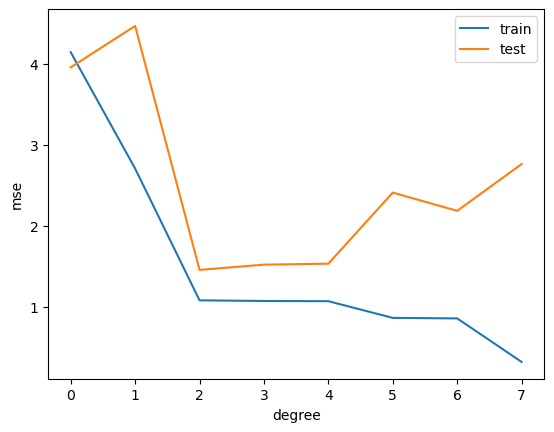

In [12]:
plt.plot(range(degree+1), train_mse)
plt.plot(range(degree+1), test_mse)
plt.legend(['train', 'test'])
plt.xticks(range(degree+1))
plt.xlabel('degree')
plt.ylabel('mse')

## Bias-Variance Tradeoff

The [bias–variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) describes the relationship between a model's complexity, the accuracy of its predictions, and how well it can generalize to new data.

The error here is the **expected value** of the test error, which is the expected error of the model when we apply it to new data.

Why **expected value**? There are two source of randomness in the model:

- The randomness of the training data: we have a random sample from the population, and the model will fit these data differently each time we draw a new sample.

- The randomness of the "noise": the noise can come from measurement error or other factors that are not included in the model.
For example, if we use some features of house to predicted the price, the price is not only determined by the feature, but also by other factors such as the location, the economy, etc, that are not included in the model. In this case, our dataset might have some houses with the same features but different prices.

The expected value of the test error can be decomposed into three parts:

1. **Bias** is the inherent error of the model even with infinite data. For example, the model might assume a linear relationship, but the true relationship is not linear.

2. **Variance** is the error due to the model's sensitivity to the training data. Notice that the training data consists of random samples from the population: if we have a different batch of training data, the model will fit these data differently, and therefore the parameters are different when the training data changes.

3. **noise** is "inherent" or "irreducible" error due to the randomness of the data. For example, the data might be noisy, or there might be other variables that affect the output.

In general, as we increase the number of tunable parameters in a model, such as the degree of the polynomial, the model becomes more flexible and can better fit the training data. It is said to have lower bias. However, more flexible model is also better at fitting the noise. Each time we draw a different batch of training data, the model will fit these data differently, and there is greater variance in the model's estimated parameters. It is said to have higher variance.

![tradeoff](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Bias_and_variance_contributing_to_total_error.svg/2880px-Bias_and_variance_contributing_to_total_error.svg.png)

But this is not the whole story. See [On the Bias-Variance Tradeoff: Textbooks Need an Update](https://www.bradyneal.com/bias-variance-tradeoff-textbooks-update#suggested-updates-to-textbooks-courses-and-our-mental-models) for more details.

